In [58]:
# load and autoreload
from IPython import get_ipython
# noinspection PyBroadException
try:
    _magic = get_ipython().magic
    _magic('load_ext autoreload')
    _magic('autoreload 2')
except:
    pass
    

import os 
import glob
import sys
import pprint
import datetime as dt
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt 
import xarray as xr 
import seaborn as sns
import cartopy as crt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
f = './data/south.america.subnational.mortality.txt'

In [60]:
df = pd.read_csv(f)

In [61]:
IC,CN,AI,AN,FR,DT,DE = ('iso_code', 'country_name', 'adm1_isocode', 'adm1_name', 'frequency',
       'date', 'deaths')

In [62]:
nam = df.drop_duplicates([CN,AN])[[CN,AN,AI]]

In [63]:
con = df.drop_duplicates(CN)[CN]

In [64]:
nam.to_csv('./data/coun_adm.csv')

In [65]:
cdf = pd.read_csv('./data/city_data.csv',na_values='QuantityMagnitude[Missing["NotAvailable"]]')
cdf['Elevation'] = cdf['Elevation']/1000

In [66]:
g1= cdf.groupby('AdministrativeDivision')
g= cdf.groupby('Country')

In [67]:
c1 = cdf[cdf['Elevation'].notna()].copy()
c1['pop_el'] = c1['Population']*c1['Elevation']

In [68]:
g1 = c1.groupby('AdministrativeDivision')

In [69]:
wh = (g1['pop_el'].sum()/g1['Population'].sum())
wh.name = 'weighted_height'
div = wh.to_frame()

In [70]:
div['pop'] = g1['Population'].sum()

In [71]:
from statsmodels.stats.weightstats import DescrStatsW

In [72]:
st = {}
for g,v in g1:
    values = v['Elevation']
    weights = v['Population']
    st[g]=DescrStatsW(values, weights=weights, ddof=1).std
st = pd.Series(st)

In [73]:
div['stw']=st

In [74]:
d1 = div.sort_values('pop',ascending=False)

In [75]:
df['dt']=pd.to_datetime(df['date'])
df1 = df.set_index('dt')

In [76]:
df2=df1.groupby(['adm1_isocode',pd.Grouper(freq='M')]).sum()['deaths'].unstack().T

In [77]:
df3 = df2['2019-01-01':'2019-12-31']

In [78]:
df3.index = df3.index.month

In [79]:
df3.isna().sum().sum()

0

In [80]:
mm = df2['2020-03':'2021-07']

In [81]:
mm.index = mm.index.month

In [82]:
m2 = mm.sum()/(mm * 0 + df3).sum()

In [83]:
m1 = (mm/df3).mean()

In [84]:
adm_dic=pd.read_csv('./data/adm_dic.csv')

In [85]:
m2.name='ratio'
m3 = m2.to_frame()

In [86]:
f1 = pd.merge(m2,adm_dic,left_index=True, right_on='admi',how='inner',
         validate='1:1')

In [87]:
Couns = ['Bolivia','Peru','Ecuador','Colombia']

In [88]:
f2 = pd.merge(d1.drop('pop',axis=1),f1,left_index=True,
         right_on='mname',validate='1:1')

f2 = f2.sort_values('pop',ascending=False)
f2 = f2[f2['ratio']<3]
# bo=f2['country']=='Brazil'
# f2 = f2[bo]

cme = f2.groupby('country').median()

f2 = pd.merge(cme,f2,left_on='country',right_on='country',suffixes=['_r',''])
f2['ratio']=f2['ratio']-f2['ratio_r']

f2 = f2[f2['country'].isin(Couns)]

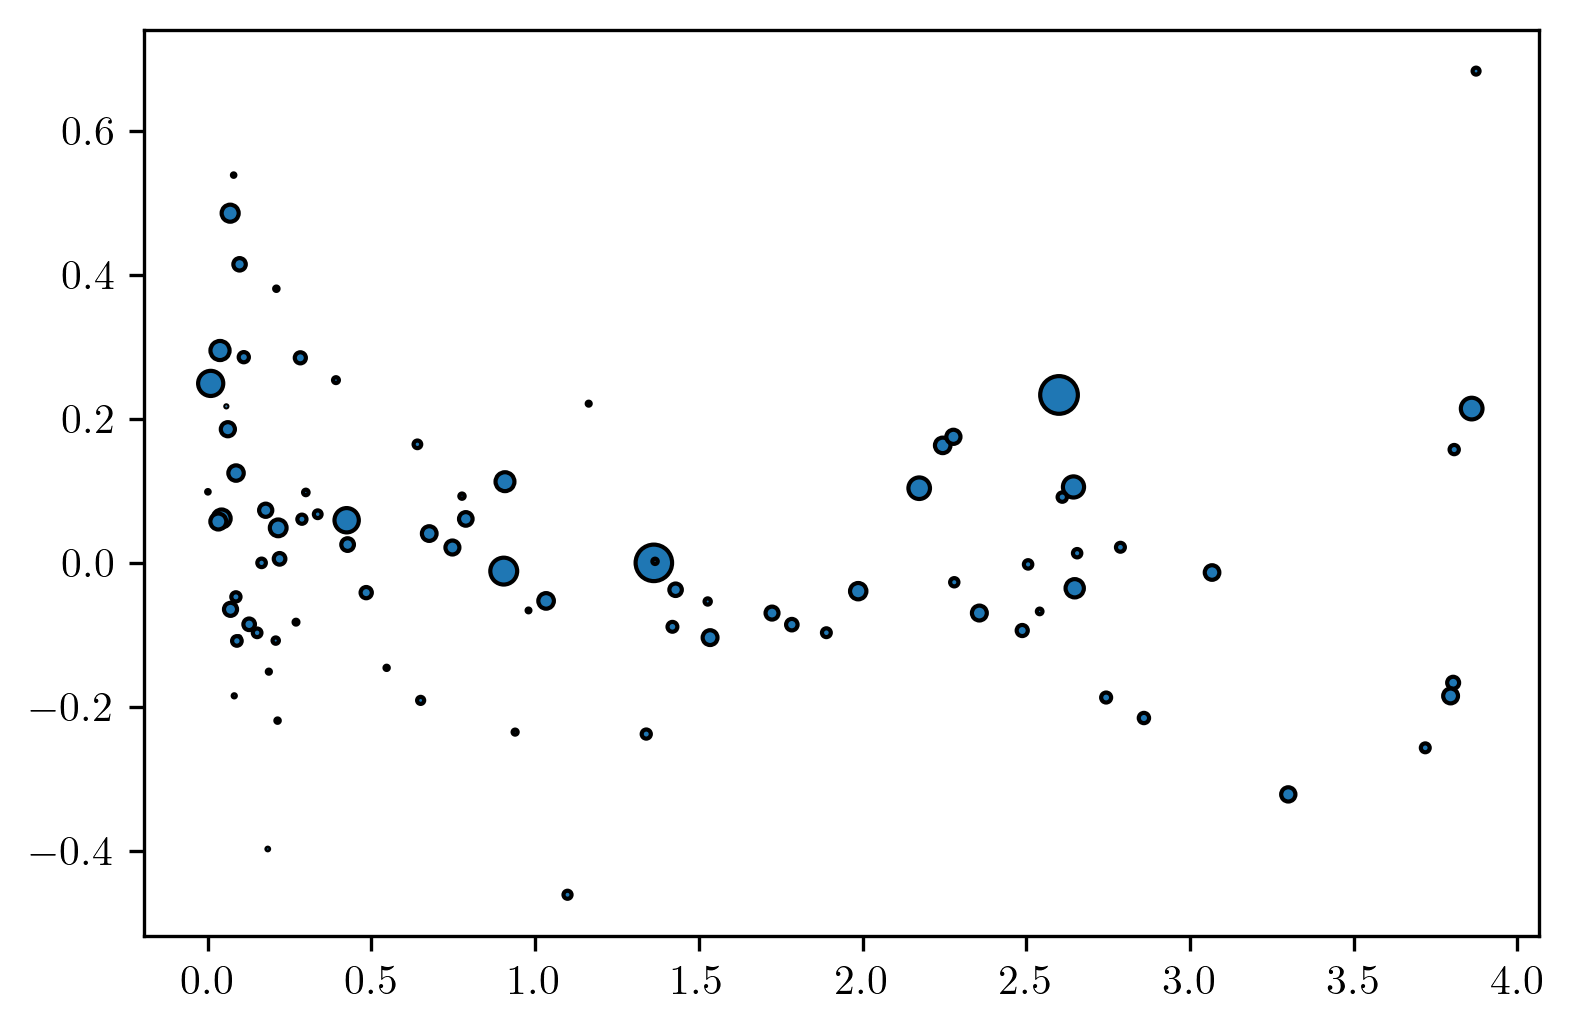

In [89]:
f,ax= plt.subplots(dpi=300)
ax.scatter(
    f2['weighted_height'],
    f2['ratio'],
    s=f2['pop']/100000,
    edgecolors='k'
)
# ax.set_ylim(.5,3)

In [90]:
mea = f2['ratio'].mean()

wmea = (f2['ratio']*f2['pop']).sum()/f2['pop'].sum()

In [91]:
co = f2['country']

In [92]:
dic_ = co.drop_duplicates().reset_index(drop=True).reset_index().set_index('country')['index'].to_dict()

In [93]:
f2['ci']=f2['country'].replace(dic_)

In [94]:
cm = plt.get_cmap('tab10')

In [95]:
cs = [cm(i) for l,i in f2['ci'].items()]

In [96]:
from sklearn.linear_model import QuantileRegressor,LinearRegression

In [97]:
qr = QuantileRegressor(alpha=0)
qr1 = LinearRegression()
qr2 = LinearRegression()

In [98]:
from sklearn.preprocessing import StandardScaler

In [99]:
f2_ = f2.sort_values('weighted_height')
X = f2_[['weighted_height']]
y = f2_[['ratio']]

In [100]:
s1 = StandardScaler()
s2 = StandardScaler()

In [101]:
X1 = s1.fit_transform(X)
y1 = s2.fit_transform(y)

In [102]:
qr.fit(X1,y1[:,0])
qr1.fit(X1,y1[:,0])
qr2.fit(X,y.values[:,0])

LinearRegression()

In [103]:
yp11 = qr.predict(X1)
yp12 = qr1.predict(X1)
yp13 = qr2.predict(X)

In [104]:
yp111 = s2.inverse_transform(yp11.reshape(-1,1))[:,0]
yp112 = s2.inverse_transform(yp12.reshape(-1,1))[:,0]

In [105]:
means = {}
wmeans_ = {}
fits = {}
f_xy = {}
for c in dic_.keys():
    boo = f2['country']==c
    means[c]=f2[boo]['ratio'].mean()
    _f = f2[boo].sort_values('weighted_height')
    wm = (_f['ratio'] * _f['pop']).sum()/_f['pop'].sum()
    wmeans_[c]=wm
    
    
    lr = QuantileRegressor(alpha=0)
#     lr = LinearRegression()
    _X = _f[['weighted_height']]
    _y = _f['ratio']
    lr.fit(_X,_y)
    fits[c] = lr
    f_xy[c] = [_X.values[:,0],lr.predict(_X)]
    

In [106]:
means = pd.Series(means).sort_values(ascending=False).to_dict()
dic = {}
wmeans = {}
for i,v in means.items():
    dic[i] = dic_[i]
    wmeans[i] = wmeans_[i]

dic = {'Peru': 6,
 'Bolivia': 0,
 'Ecuador': 4,
 'Colombia': 3,
 }

In [107]:


doff = {
    'Peru': 0,
     'Bolivia': 0,
     'Ecuador': -.015,
     'Colombia': -.02,
     'Brazil': 0,
     'Paraguay': 0,
     'Chile': 0,
     'Uruguay': 0
}

In [108]:
coef = np.round(np.round(qr2.coef_[0],2)+.000000001,2)

In [109]:
f2['ci']=f2['country'].replace(dic)
cs = [cm(i) for l,i in f2['ci'].items()]

In [110]:
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

In [111]:
_x = f2_['weighted_height'].values
_y = f2_['ratio'].values

import statsmodels.api as sm
import numpy as np

# include constant in ols models, which is not done by default
_x = sm.add_constant(_x)

model = sm.OLS(_y,_x)
results = model.fit()

s=results.summary2()
c1,x1 = s.tables[1]['[0.025']
c2,x2 = s.tables[1]['0.975]']

fy = f'$y = {coef:.2f}x + {qr2.intercept_:.2f}$'

fy = f'  $y = {coef:.2f} ({x1:.2f},{x2:.2f}) x + {qr2.intercept_:.2f}({c1:.2f},{c2:.2f})$'


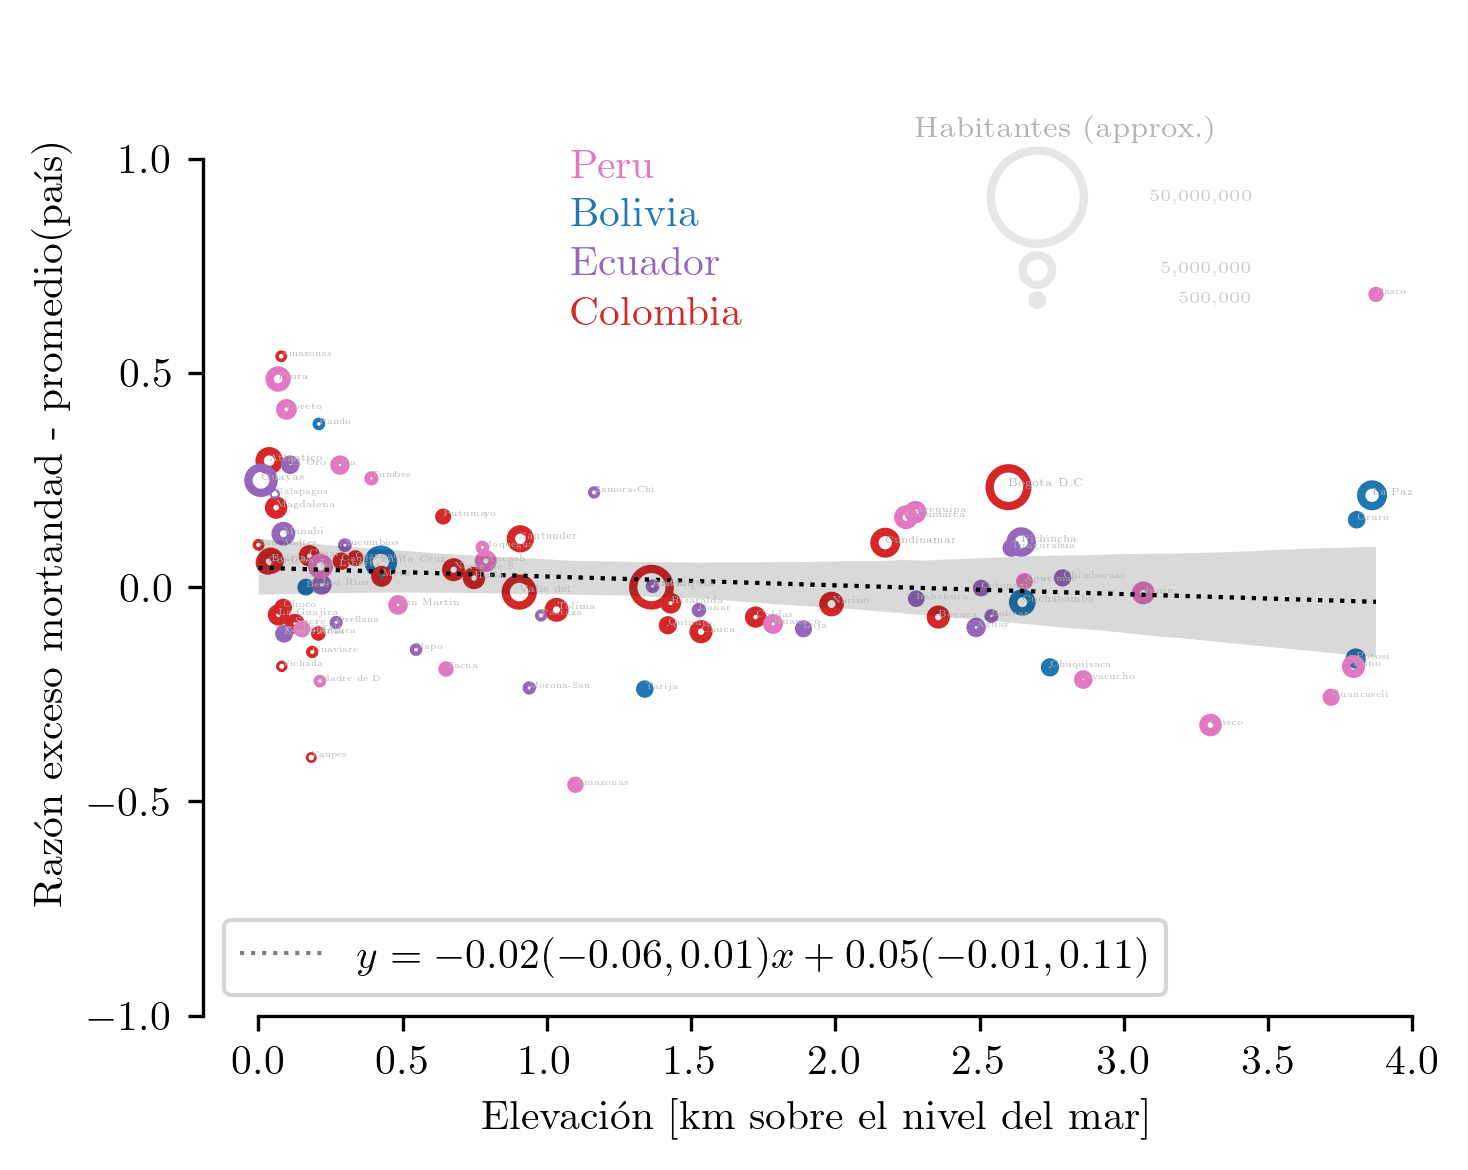

In [112]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
f,ax= plt.subplots(dpi=300,figsize=(5,4))
ax.scatter(
    f2['weighted_height'],
    f2['ratio'],
    s=f2['pop']/100000,
    edgecolors=cs,
    lw=2,
    facecolor='none'
)
ax.set_ylim(-1,1.3)
# ax.axhline(wmea,c='.5',ls='--',lw=1)
ax.plot(X.values[:,0],yp13,ls=':',c='.5',lw=1,label=fy)
ax.legend(loc='lower left')
# ax.text(X.values[-1,0],yp13[-1],fy,va='center',fontsize=6,c='.5')



sns.despine(f,trim=True)
ax.set_ylabel('Razón exceso mortandad - promedio(país)')
ax.set_xlabel('Elevación [km sobre el nivel del mar]')

# al = {0:'bottom',1:'top'}

for i,c in enumerate(dic.keys()):
#     ax.axhline(wmeans[c],alpha=.3,lw=1,ls='--',c=cm(dic[c]))
#   ax.plot(*f_xy[c],ls='-.',lw=1,alpha=.5)
    ax.text(.3,.85-i/20,c,transform=ax.transAxes,c=cm(dic[c]))
#     ax.text(4.1,wmeans[c]+doff[c],f'$\overline{{x}}={wmeans[c]:.2f}$|{c}',
#             fontsize=5,c=cm(dic[c]),va='center')
    pass

# ax.text(4.1,wmea,f'$\overline{{x}}={wmea:.2f}$|prom regional',
#         fontsize=5,c='.5',va='center')

for i,r in f2.iterrows():
    ax.text(r['weighted_height'],r['ratio'],
           r['adm'][:10], fontsize = (r['pop'])**.5/5000+2,
            c='.7'
           )
xx = np.array([2.7,2.7,2.7])
yy = np.array([2.61,2.44,2.37])-1.7
pp = [5e7,5e6,5e5]
ax.scatter(
    xx,
    yy,
    s=np.array(pp)/100000,
    lw=2,
    facecolor='none',
    edgecolor='.9')

for x,y,p in zip(xx,yy,pp):
    ax.text(x+.75,y,f'{int(p):,}',va='center',ha='right',fontsize=4,c='.8')
    pass
    
ax.text(xx[0]+.1,2.75-1.7,'Habitantes (approx.)',fontsize=7,c='.7',ha='center')

sns.regplot(x=_x[:,1],y=_y,scatter=False,line_kws={'lw':1,'color':'k','ls':':'},ax=ax)

f.tight_layout()
f.savefig('reg_alt_alt_corr.pdf')
f.savefig('reg_alt_alt_corr.png')

In [113]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.004   
Dependent Variable: y                AIC:                -36.1290
Date:               2021-12-30 00:59 BIC:                -31.2203
No. Observations:   86               Log-Likelihood:     20.064  
Df Model:           1                F-statistic:        1.363   
Df Residuals:       84               Prob (F-statistic): 0.246   
R-squared:          0.016            Scale:              0.037592
-------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
-------------------------------------------------------------------
const       0.0454     0.0300    1.5122   0.1342   -0.0143   0.1051
x1         -0.0205     0.0176   -1.1674   0.2464   -0.0555   0.0144
-----------------------------------------------------------------
Omnibus:              13.594       Durbin-Watson:          1.728 
Prob(Omnibus):        0.001        Jarque-Bera (JB):       18.599
Skew:                 0.708        Prob(JB):               0.000 
Kurtosis:             4.784        Condition No.:          3     
=================================================================

"""